In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_compression as tfc
import matplotlib.pyplot as plt

import os
import h5py

from BalleFFP_improved import BalleFFP
from read_data import read_data_numpy

2023-03-07 23:09:56.198513: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 23:09:56.337381: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-07 23:09:56.877354: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ubuntu/data/miniconda3/envs/tf2/lib/
2023-03-07 23:09:56.877444: W tensorflow/co

## General Settings

In [2]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [3]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"]   = 14

In [4]:
tf.config.set_visible_devices([], 'GPU')

2023-03-07 23:09:59.732171: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 23:09:59.733603: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 23:09:59.742140: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 23:09:59.743422: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 23:09:59.744597: I tensorflow/compiler/xla/stream_executo

## Functions

In [5]:
def get_model_files(folder, name):
    files  = os.listdir(folder)
    files  = [f for f in files if name in f]
    models = [f for f in files if "model" in f]
    losses = [f for f in files if "losses" in f]
    return models, losses

In [6]:
def show_image_comparison(img, reco, id, format):
    """Visualize the original image and the reconstructed image side by side."""
    if format=='channels_first':
        img  = np.transpose(img, (1, 2, 0))
        reco = np.transpose(reco, (1, 2, 0))
    
    # check if the images are normalized
    norm_img  = np.max(img)  <= 1.0
    norm_reco = np.max(reco) <= 1.0

    # Create a 4x4 grid of images
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7), constrained_layout=True)
    axes[0].imshow(img  if norm_img  else img.astype(np.uint8)) 
    axes[1].imshow(reco if norm_reco else reco.astype(np.uint8)) 
    
    axes[0].axis('off')
    axes[1].axis('off')
    
    fig.suptitle('Original image (left) and reconstructed image (right) (id: {})'.format(id))

    # Show the plot
    plt.show()

def show_image_comparison_bitrate(img, reco, id, format, compressor):
    """Visualize the original image and the reconstructed image side by side."""
    if format=='channels_first':
        img  = np.transpose(img, (1, 2, 0))
        reco = np.transpose(reco, (1, 2, 0))
    
    # check if the images are normalized
    norm_img  = np.max(img)  <= 1.0
    norm_reco = np.max(reco) <= 1.0

    bits_img     = np.product(img.shape)*8
    _, bits_reco = compressor(np.expand_dims(img, 0))

    print('Bitrate shape:', bits_reco.shape)

    # Create a 4x4 grid of images
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7), constrained_layout=True)
    axes[0].imshow(img  if norm_img  else img.astype(np.uint8)) 
    axes[1].imshow(reco if norm_reco else reco.astype(np.uint8)) 
    
    axes[0].axis('off')
    axes[1].axis('off')

    axes[0].set_title(f'{bits_img} bits')
    axes[1].set_title(f'{int(tf.reduce_sum(bits_reco))} bits')
    
    fig.suptitle('Original image (left) and reconstructed image (right) (id: {})'.format(id))

    # Show the plot
    plt.show()
    
    return int(tf.reduce_sum(bits_reco))

In [7]:
def select_random_images(data, n):
    """Selects n random images from the data."""
    idx = np.random.choice(data.shape[0], n, replace=False)
    return data[idx], idx

In [8]:
# Get the tab10 colormap from matplotlib
tab10 = plt.get_cmap('tab10') # type: ignore

# Get the number of colors in the tab10 colormap
num_colors = tab10.N

# Create a list to store the hex color codes
hex_colors = []

# Loop through each color in the tab10 colormap and convert it to a hex color code
for i in range(num_colors):
    rgb_color = tab10(i)[:3]  # Get the RGB values of the color
    hex_color = '#{:02x}{:02x}{:02x}'.format(*[int(x * 255) for x in rgb_color])  # Convert the RGB color to a hex color code
    hex_colors.append(hex_color)

# Print the list of hex color codes
print(hex_colors)


['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [9]:
def PSNR(data, normalized = False):

    """
    INPUTS: original image and its compressd version
    """
    mse = tf.reduce_mean((data[0] - data[1]) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 10000
    if normalized: 
        max_pixel = 1.0 # if is not normalize
    else: 
        max_pixel = 255.0

    psnr = 20 * tf.experimental.numpy.log10(max_pixel / tf.sqrt(mse)) #from definition
    return psnr

def psnr_onbatch(img, img_reco):

    if type(img) == np.ndarray:
        img = tf.constant(img)

    psnrs       = tf.map_fn(PSNR, (img, img_reco), dtype=(tf.float32, tf.float32), fn_output_signature=tf.float32)
    psnr_mean   = tf.reduce_mean(psnrs)
    psnr_var    = tf.math.reduce_variance(psnrs)

    return psnr_mean.numpy(), tf.sqrt(psnr_var).numpy()


def msssim_onbatch(img, img_reco, ch_format, normalized=False):
    if ch_format == 'channels_first':
        img = img.transpose((0, 2, 3, 1))
    if type(img) == np.ndarray:
        img = tf.constant(img)

    msssim = tf.image.ssim_multiscale(img, img_reco, 1.0 if normalized else 255.0, filter_size=6)
    return tf.reduce_mean(msssim).numpy(), tf.sqrt(tf.math.reduce_variance(msssim)).numpy()

## Classes

In [10]:
class Compressor(tf.keras.Model):

    def __init__(self, model, cr):

        super(Compressor, self).__init__()

        self.encoder = model.encoder
        self.prior   = model.prior
        self.bemodel = tfc.ContinuousBatchedEntropyModel(
            prior = self.prior,
            coding_rank=cr,
            compression=True
        )

    def call(self, inputs):

        encoded = self.encoder(inputs, training=False)

        _, bits   = self.bemodel(encoded, training=False)
        bitstring = self.bemodel.compress(encoded)

        return bitstring, bits

## Constants

In [11]:
DATA_FOLDER  = "../data/stl10/stl10_binary/"
DATA_FILE    = "unlabeled_X.bin"

CH_FORMAT = "channels_last"
EPOCHS    = 50
NORM      = "normFalse"
COD_RANK  = 1

MODEL_FOLDER = "../models/"

## Load Data

In [12]:
data_path = os.path.join(DATA_FOLDER, DATA_FILE)
data      = read_data_numpy(data_path, CH_FORMAT).astype('float32') 

if NORM == "normTrue":
    # normalize the data to [0,1]
    data = data / 255.0

## Choose the trained model

In [13]:
# name = "ffp_{}_epochs{}_{}_l{}_cr{}".format(CH_FORMAT, EPOCHS, NORM, LAMBDA, COD_RANK)
name = f"cr{COD_RANK}"

models, losses = get_model_files(MODEL_FOLDER, name)
for model in models:
    print(model)
print()
for loss in losses:
    print(loss)

model_ffp_channels_last_epochs50_normFalse_l0.01_cr1_20230307041231.h5
model_ffp_channels_last_epochs50_normFalse_l100.0_cr1_20230307221802.h5
model_ffp_channels_last_epochs50_normFalse_l10.0_cr1_20230307204323.h5
model_ffp_channels_last_epochs50_normFalse_l0.1_cr1_20230307055327.h5
model_ffp_channels_last_epochs50_normFalse_l1.0_cr1_20230307190820.h5

losses_ffp_channels_last_epochs50_normFalse_l1.0_cr1_20230307190820.h5
losses_ffp_channels_last_epochs50_normFalse_l10.0_cr1_20230307204323.h5
losses_ffp_channels_last_epochs50_normFalse_l0.01_cr1_20230307041231.h5
losses_ffp_channels_last_epochs50_normFalse_l0.1_cr1_20230307055327.h5
losses_ffp_channels_last_epochs50_normFalse_l100.0_cr1_20230307221802.h5


In [14]:
# from the list of models find the lambda value right after "l" and before  the following "_"
lambdas_from_models = [float(model.split("_")[6].split("l")[1].split("_")[0]) for model in models]
print(lambdas_from_models)

[0.01, 100.0, 10.0, 0.1, 1.0]


In [15]:
lambdas_from_losses = [float(loss.split("_")[6].split("l")[1].split("_")[0]) for loss in losses]
print(lambdas_from_losses)

[1.0, 10.0, 0.01, 0.1, 100.0]


In [16]:
# sort the models and losses according to the lambda values
models_sorting = np.argsort(lambdas_from_models)
losses_sorting = np.argsort(lambdas_from_losses)
print(models_sorting)
print(losses_sorting)

[0 3 4 2 1]
[2 3 0 1 4]


In [17]:
models  = [models[i] for i in models_sorting]
losses  = [losses[i] for i in losses_sorting]
lambdas = [lambdas_from_models[i] for i in models_sorting]

In [18]:
models_path = [os.path.join(MODEL_FOLDER, model) for model in models]
losses_path = [os.path.join(MODEL_FOLDER, loss) for loss in losses]

for model_path in models_path:
    print("Loading model from: {}".format(model_path))

Loading model from: ../models/model_ffp_channels_last_epochs50_normFalse_l0.01_cr1_20230307041231.h5
Loading model from: ../models/model_ffp_channels_last_epochs50_normFalse_l0.1_cr1_20230307055327.h5
Loading model from: ../models/model_ffp_channels_last_epochs50_normFalse_l1.0_cr1_20230307190820.h5
Loading model from: ../models/model_ffp_channels_last_epochs50_normFalse_l10.0_cr1_20230307204323.h5
Loading model from: ../models/model_ffp_channels_last_epochs50_normFalse_l100.0_cr1_20230307221802.h5


## Train/Test loss

In [19]:
# for every loss file, load them as two numpy arrays train_loss and test_loss
train_losses = []   
test_losses  = []

for loss_path in losses_path:
    print("Loading losses from: {}".format(loss_path))
    with h5py.File(loss_path, 'r') as f:
        train_losses.append(np.array(f['train']))
        test_losses.append(np.array(f['test']))

Loading losses from: ../models/losses_ffp_channels_last_epochs50_normFalse_l0.01_cr1_20230307041231.h5
Loading losses from: ../models/losses_ffp_channels_last_epochs50_normFalse_l0.1_cr1_20230307055327.h5
Loading losses from: ../models/losses_ffp_channels_last_epochs50_normFalse_l1.0_cr1_20230307190820.h5
Loading losses from: ../models/losses_ffp_channels_last_epochs50_normFalse_l10.0_cr1_20230307204323.h5
Loading losses from: ../models/losses_ffp_channels_last_epochs50_normFalse_l100.0_cr1_20230307221802.h5


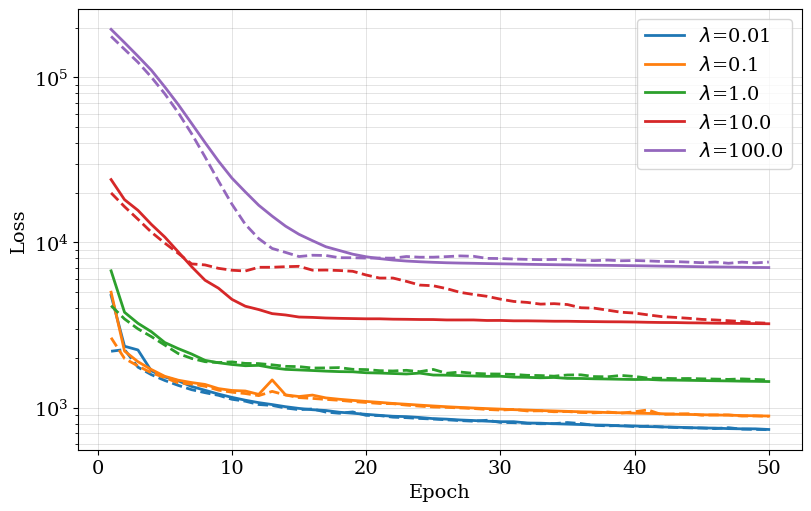

In [21]:
fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
ax.grid(True, which='both', ls='-', lw=0.5, c='grey', alpha=0.3)

for i in range(len(train_losses)):
    epochs = np.arange(1, len(train_losses[i])+1)

    ax.plot(epochs, train_losses[i], ls="-", color=hex_colors[i], lw=2, label=f"$\lambda$={lambdas[i]}")
    ax.plot(epochs, test_losses[i], ls="--", color=hex_colors[i], lw=2)

ax.legend()

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.set_yscale('log')

# fig.savefig("./plots/losses_cr1_lambda_scan.png", dpi=300, facecolor="w")

plt.show()

## Image Reconstruction

In [20]:
vae = BalleFFP(N=128, M=192, k2=3, c=3, format=CH_FORMAT)

if CH_FORMAT == 'channels_first':
    x = tf.zeros((1, 3, 96, 96))
    
elif CH_FORMAT == 'channels_last':
    x = tf.zeros((1, 96, 96, 3))
else:
    raise ValueError("CH_FORMAT must be either 'channels_first' or 'channels_last'")

# call the model to create the weights
_ = vae(x)
    
# load the weights from the .h5 file
# vae_list.append(vae.load_weights(model_path))

2023-03-07 23:10:19.930361: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
img, ids = select_random_images(data, 1)

Loading model from: ../models/model_ffp_channels_last_epochs50_normFalse_l0.01_cr1_20230307041231.h5
Bitrate shape: (1, 9, 9)


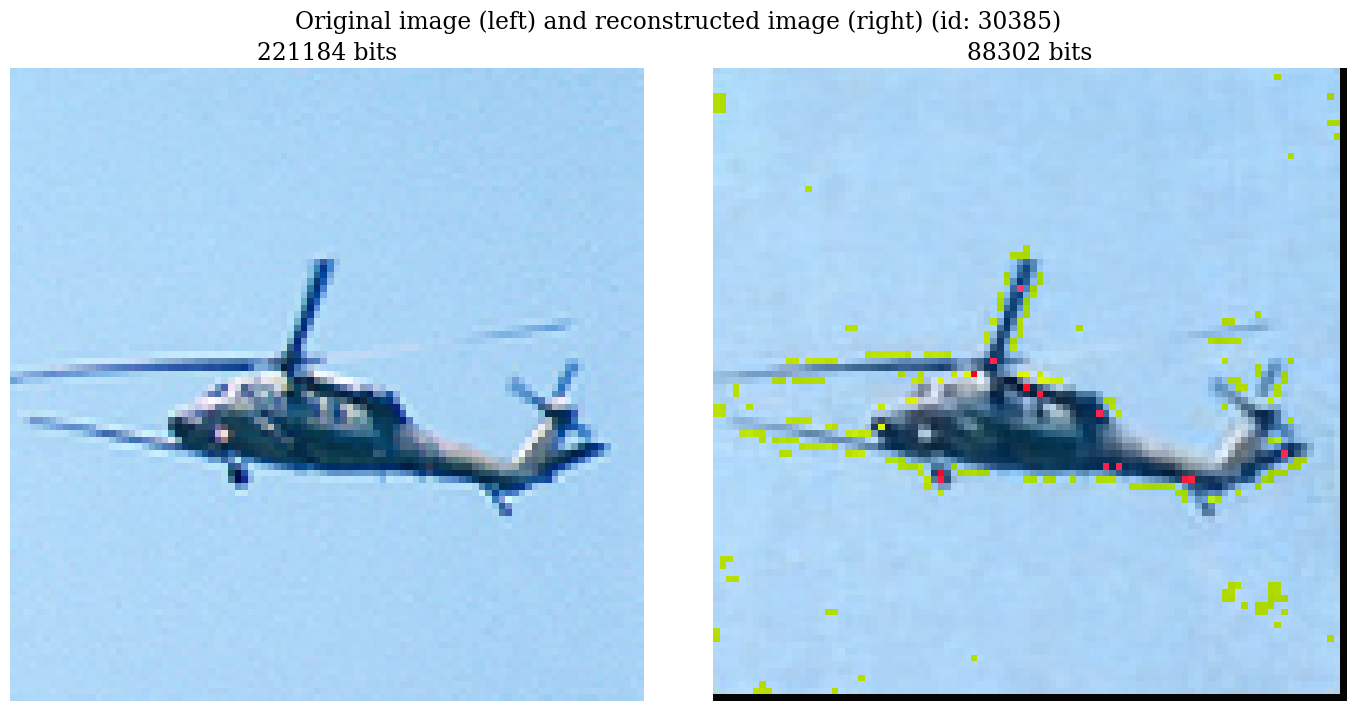

Loading model from: ../models/model_ffp_channels_last_epochs50_normFalse_l0.1_cr1_20230307055327.h5
Bitrate shape: (1, 9, 9)


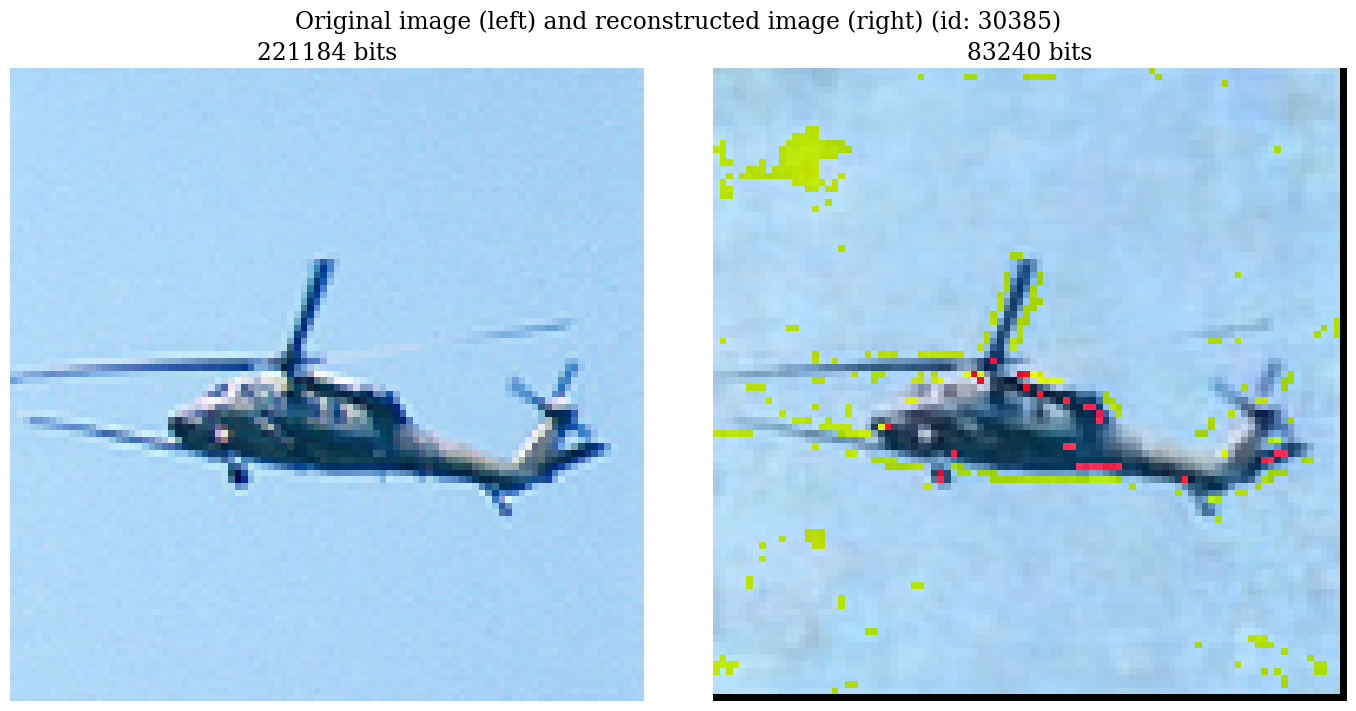

Loading model from: ../models/model_ffp_channels_last_epochs50_normFalse_l1.0_cr1_20230307190820.h5
Bitrate shape: (1, 9, 9)


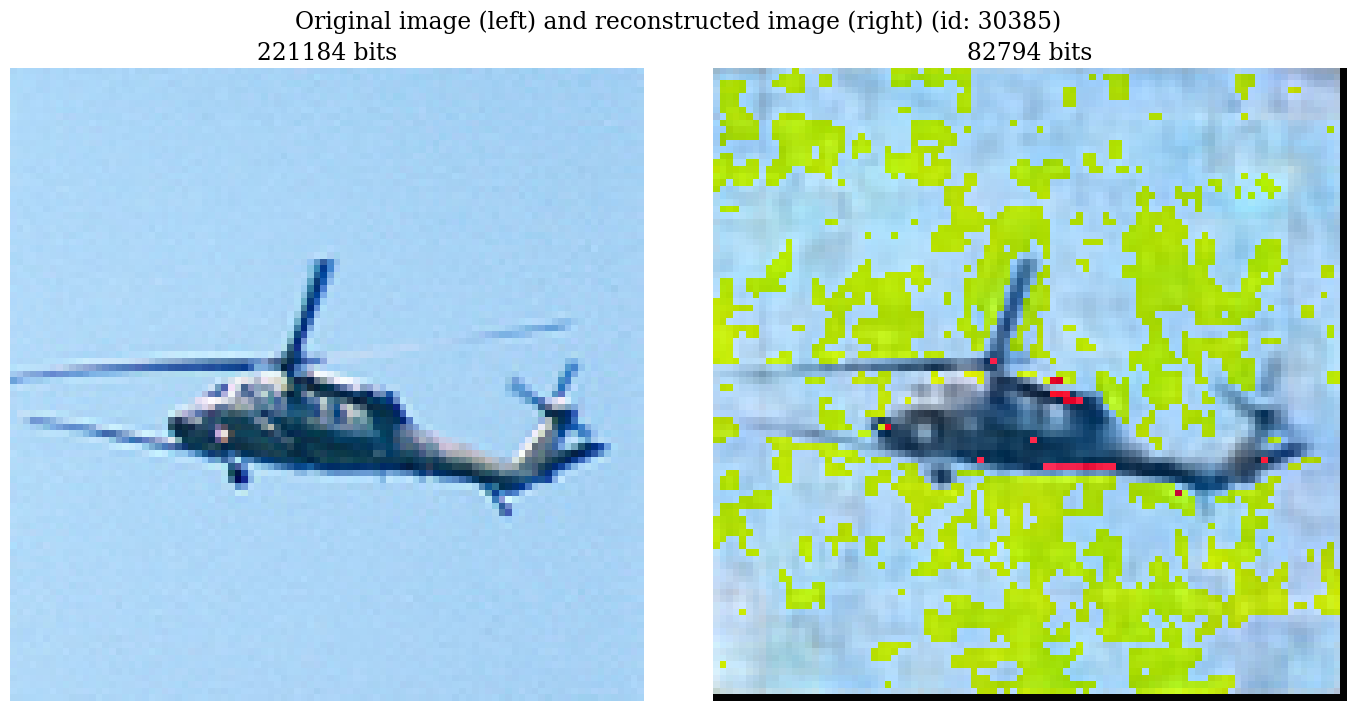

Loading model from: ../models/model_ffp_channels_last_epochs50_normFalse_l10.0_cr1_20230307204323.h5
Bitrate shape: (1, 9, 9)


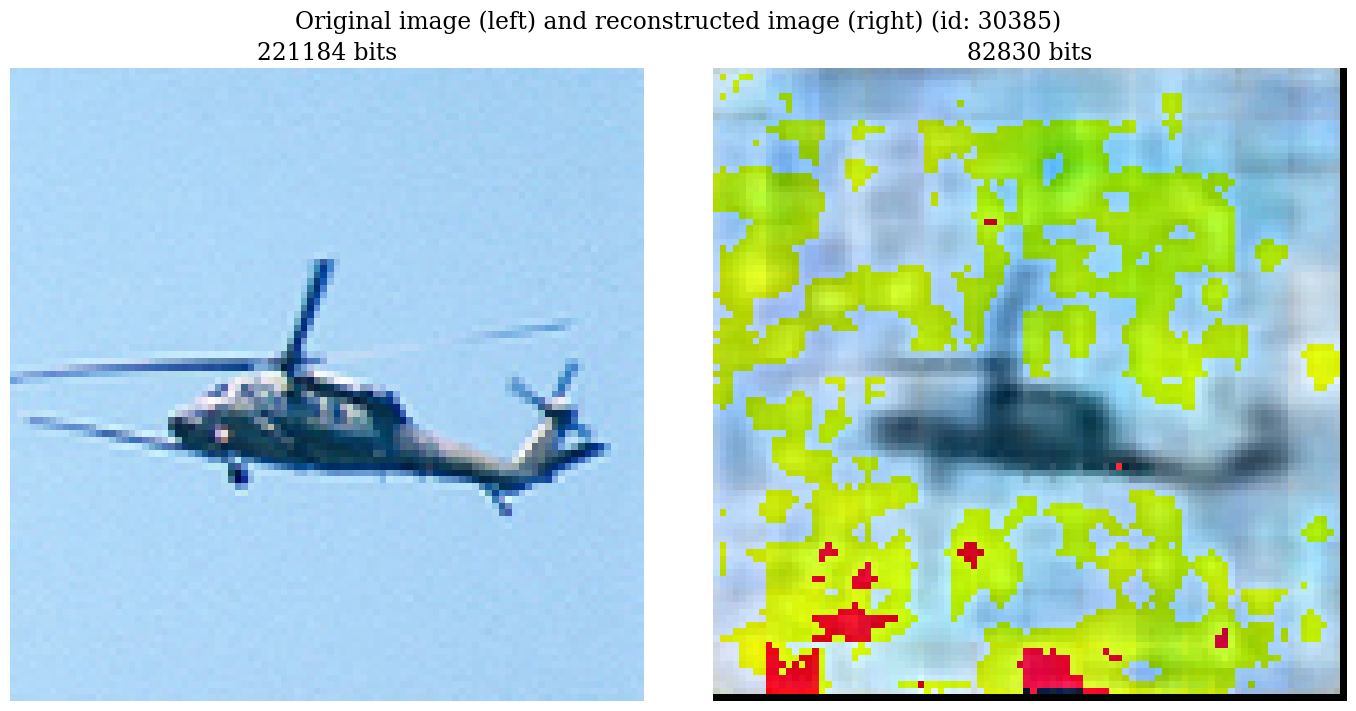

Loading model from: ../models/model_ffp_channels_last_epochs50_normFalse_l100.0_cr1_20230307221802.h5
Bitrate shape: (1, 9, 9)


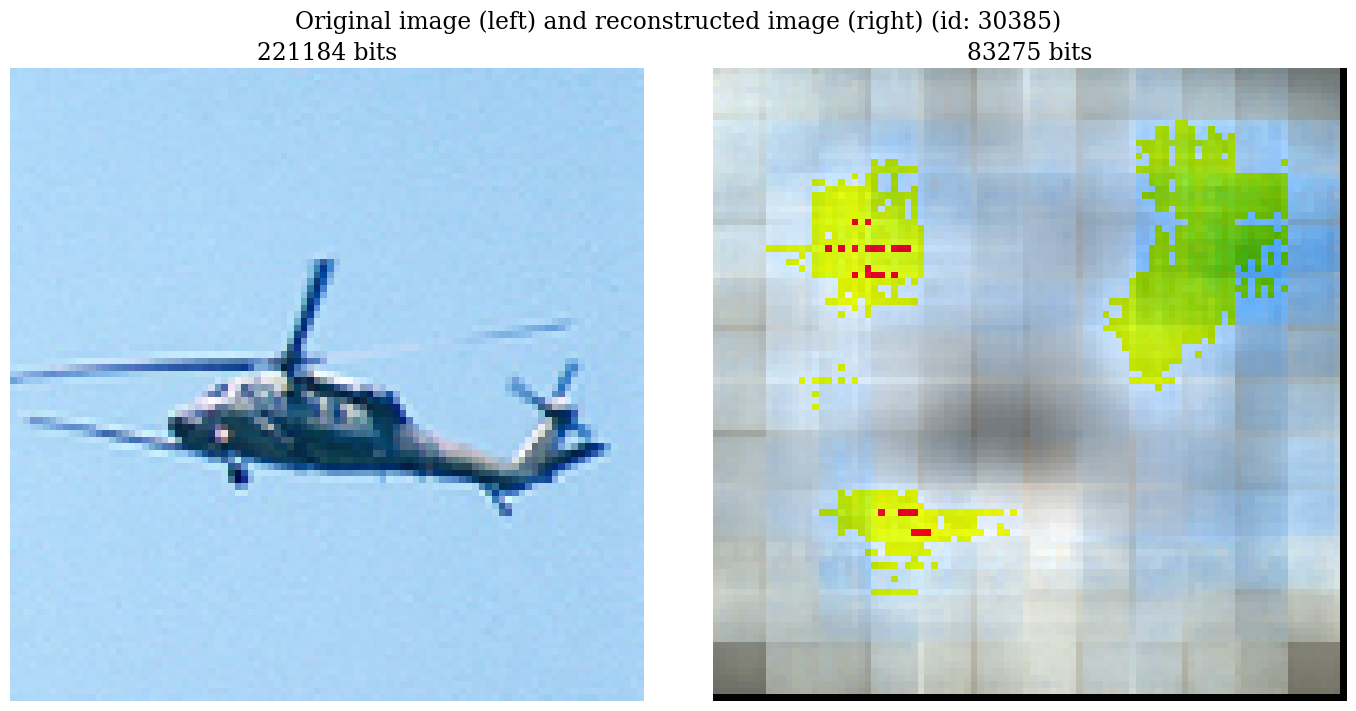

In [33]:
bit_rates = []

for model_path in models_path:
    print("Loading model from: {}".format(model_path))
    vae.load_weights(model_path)
    img_reco, rate_reco = vae(img) # type: ignore
    
    compressor = Compressor(vae, COD_RANK)
    
    bit_rates_per_image = []

    for i in range(img.shape[0]):
        bits_reco = show_image_comparison_bitrate(img[i], img_reco[i], ids[i], CH_FORMAT, compressor)
        bit_rates_per_image.append(bits_reco)
    
    bit_rates.append(bit_rates_per_image)

## Compression ratio

In [34]:
# compute the bitrates for the original images
original_bit_rate = np.product(img[0].shape)*8

print("Original bit rate: {}".format(original_bit_rate))

Original bit rate: 221184


In [79]:
def bitrate_onbatch(img, compressor):
    
    if type(img) == np.ndarray:
        img = tf.constant(img)
        
    bits = compressor(x)[1]
    

    # bit mean: resuce sum of all dimensions except the first one and then reduce mean over the first dimension
    bit_mean = tf.math.reduce_mean(tf.math.reduce_sum(bits, axis=tuple(range(1, bits.shape.ndims))))
    bit_std  = tf.math.reduce_std(tf.math.reduce_sum(bits, axis=tuple(range(1, bits.shape.ndims))))
    
    return bit_mean, bit_std

In [80]:
n_images = 1000

img, ids = select_random_images(data, n_images)

bit_rates_mean_list = []
bit_rates_err_list  = []

for model_path in models_path:
    print("Loading model from: {}".format(model_path))
    vae.load_weights(model_path)
    img_reco, rate_reco = vae(img) # type: ignore
    
    compressor = Compressor(vae, COD_RANK)

    bit_rates_mean, bit_rates_std = bitrate_onbatch(img_reco, compressor)
    
    print(f"Bitrate: {bit_rates_mean.numpy():.2f} +/- {bit_rates_std.numpy():.2f} bits/pixel")
    
    bit_rates_mean_list.append(bit_rates_mean)
    bit_rates_err_list.append(bit_rates_std)

Loading model from: ../models/model_ffp_channels_last_epochs50_normFalse_l0.01_cr1_20230307041231.h5
Bitrate: 85479.23 +/- 0.00 bits/pixel
Loading model from: ../models/model_ffp_channels_last_epochs50_normFalse_l0.1_cr1_20230307055327.h5
Bitrate: 83134.03 +/- 0.00 bits/pixel
Loading model from: ../models/model_ffp_channels_last_epochs50_normFalse_l1.0_cr1_20230307190820.h5
Bitrate: 82794.50 +/- 0.00 bits/pixel
Loading model from: ../models/model_ffp_channels_last_epochs50_normFalse_l10.0_cr1_20230307204323.h5
Bitrate: 82833.43 +/- 0.00 bits/pixel
Loading model from: ../models/model_ffp_channels_last_epochs50_normFalse_l100.0_cr1_20230307221802.h5
Bitrate: 83272.51 +/- 0.00 bits/pixel


#### Plot magari da combinare con cr3 

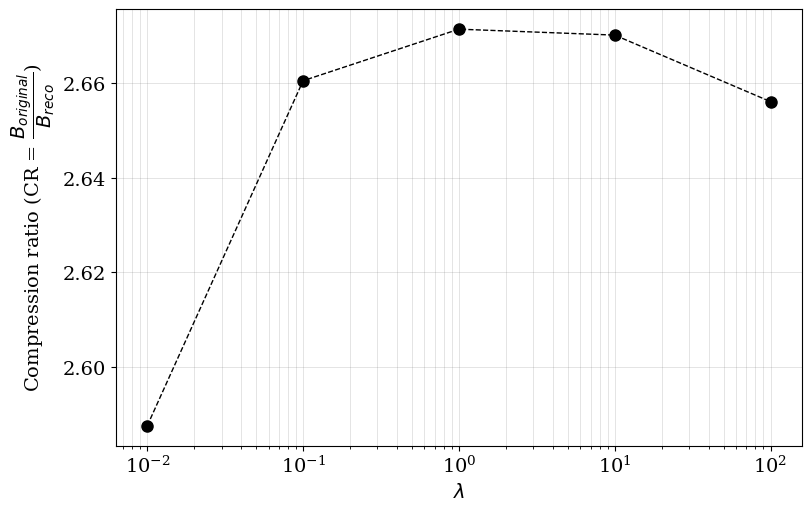

In [90]:
# plot the bitrates comparing the original image with the reconstructed images

compression_ratio = original_bit_rate / np.array(bit_rates_mean_list)
compression_ratio_err = compression_ratio * np.array(bit_rates_err_list) / np.array(bit_rates_mean_list)


fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
ax.grid(True, which='both', ls='-', lw=0.5, c='grey', alpha=0.3)

ax.errorbar(
    x          = lambdas, 
    y          = compression_ratio, 
    yerr       = compression_ratio_err, 
    ls         = "--", 
    lw         = 1, 
    marker     = "o", 
    markersize = 8, 
    color      = "k",
    # elinewidth = 2,
    # capsize    = 5,
    # capthick   = 2,
)

ax.set_xscale('log')

ax.set_xlabel("$\lambda$")
ax.set_ylabel("Compression ratio (CR = $\dfrac{B_{original}}{B_{reco}}$)")

# fig.savefig("./plots/compression_ratio_cr1_lambda_scan.png", dpi=300, facecolor="w")

plt.show()

## PSNR / MS-SIM

In [50]:
n_images = 1000

img, ids = select_random_images(data, n_images)

psnr_mean_list = []
psnr_err_list  = []

mssim_mean_list = []
mssim_err_list  = []

for model_path in models_path:
    print("Loading model from: {}".format(model_path))
    vae.load_weights(model_path)
    img_reco, rate_reco = vae(img) # type: ignore
    
    psnr_mean, psnr_err = psnr_onbatch(img, img_reco)
    
    psnr_mean_list.append(psnr_mean)
    psnr_err_list.append(psnr_err)   
    
    mssim_mean, mssim_err = msssim_onbatch(img, img_reco, CH_FORMAT, NORM) 
    
    mssim_mean_list.append(mssim_mean)
    mssim_err_list.append(mssim_err)
    
    print("PSNR: {:.2f} +/- {:.2f}".format(psnr_mean, psnr_err))
    print("MS-SSIM: {:.4f} +/- {:.4f}".format(mssim_mean, mssim_err))

Loading model from: ../models/model_ffp_channels_last_epochs50_normFalse_l0.01_cr1_20230307041231.h5
PSNR: 23.41 +/- 2.79
MS-SSIM: 0.9603 +/- 0.0329
Loading model from: ../models/model_ffp_channels_last_epochs50_normFalse_l0.1_cr1_20230307055327.h5
PSNR: 22.88 +/- 2.55
MS-SSIM: 0.9434 +/- 0.0436
Loading model from: ../models/model_ffp_channels_last_epochs50_normFalse_l1.0_cr1_20230307190820.h5
PSNR: 21.43 +/- 1.98
MS-SSIM: 0.8905 +/- 0.0601
Loading model from: ../models/model_ffp_channels_last_epochs50_normFalse_l10.0_cr1_20230307204323.h5
PSNR: 18.24 +/- 1.41
MS-SSIM: 0.7211 +/- 0.0814
Loading model from: ../models/model_ffp_channels_last_epochs50_normFalse_l100.0_cr1_20230307221802.h5
PSNR: 14.59 +/- 1.33
MS-SSIM: 0.3343 +/- 0.0931


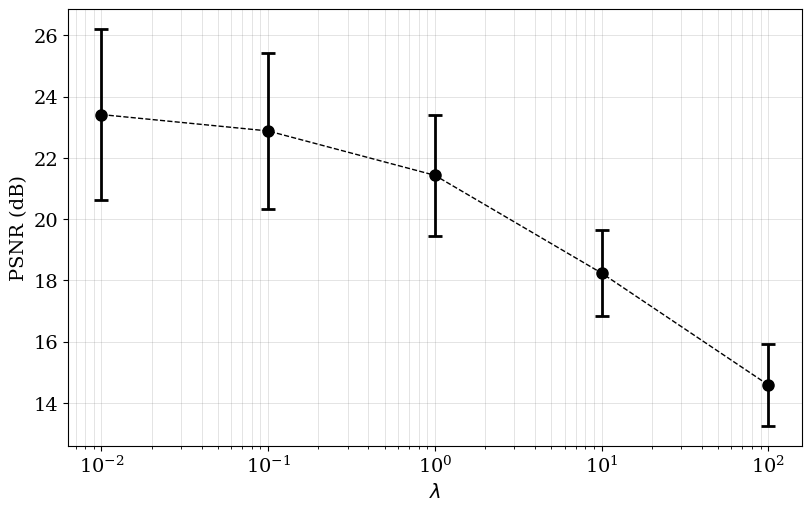

In [65]:
# plot the PSNR comparing the original image with the reconstructed images

fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
ax.grid(True, which='both', ls='-', lw=0.5, c='grey', alpha=0.3)

ax.errorbar(
    x          = lambdas, 
    y          = psnr_mean_list, 
    yerr       = psnr_err_list, 
    ls         = "--", 
    lw         = 1, 
    marker     = "o", 
    markersize = 8, 
    color      = "k",
    elinewidth = 2,
    capsize    = 5,
    capthick   = 2,
)

ax.set_xscale('log')


ax.set_xlabel("$\lambda$")
ax.set_ylabel("PSNR (dB)")

# fig.savefig("./plots/psnr_cr1_lambda_scan.png", dpi=300, facecolor="w")

plt.show()

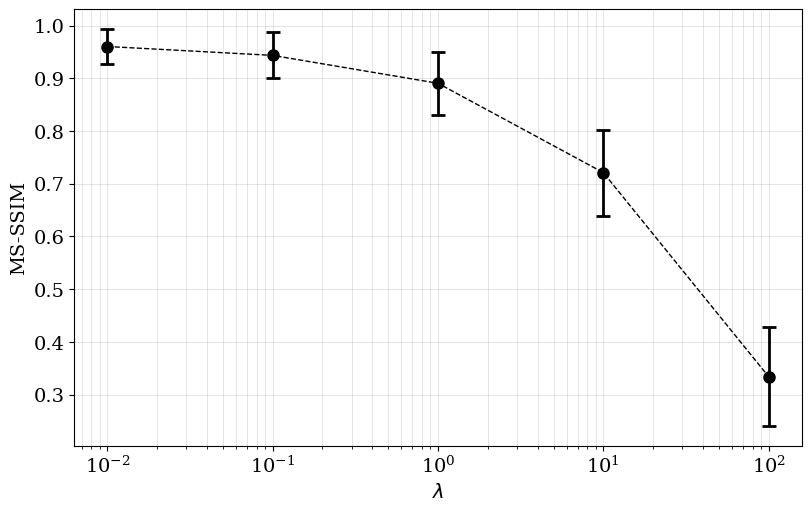

In [67]:
# plot the MSSIM comparing the original image with the reconstructed images

fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
ax.grid(True, which='both', ls='-', lw=0.5, c='grey', alpha=0.3)

ax.errorbar(
    x          = lambdas, 
    y          = mssim_mean_list, 
    yerr       = mssim_err_list, 
    ls         = "--", 
    lw         = 1, 
    marker     = "o", 
    markersize = 8, 
    color      = "k",
    elinewidth = 2,
    capsize    = 5,
    capthick   = 2,
)

ax.set_xscale('log')


ax.set_xlabel("$\lambda$")
ax.set_ylabel("MS-SSIM")

# fig.savefig("./plots/mssim_cr1_lambda_scan.png", dpi=300, facecolor="w")

plt.show()